# Regressão - Previsão do Valor de um Ativo no Dia Seguinte

## Autores
- Felipe Bakowski Nantes de Souza  
- Vinicius Grecco Fonseca Mulato  
- Victor Soares

# 1. Seleção do Dataset

**Dataset:** Dados Históricos de Preços de Ações da Apple Inc. (AAPL)  
**Fonte:** Yahoo Finance via biblioteca `yfinance`  
**URL:** https://finance.yahoo.com/quote/AAPL/history  

In [ ]:
# ============================================================================
# IMPORTS E CONFIGURAÇÃO
# ============================================================================
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib.ticker import FuncFormatter
from tensorflow.keras import layers, callbacks
from scipy.stats import normaltest
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import tensorflow as tf

# Definir seeds aleatórias para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

# ============================================================================
# AQUISIÇÃO DE DADOS
# ============================================================================
print("="*70)
print("1. SELEÇÃO DO DATASET - DOWNLOAD DOS DADOS")
print("="*70)
print("\n📥 Baixando dados da Apple Inc. (AAPL) do Yahoo Finance...")
print("   Período: Últimos 10 anos (2015-2025)")
print("   Intervalo: Diário (1d)")
print("   Ajuste: Auto-ajustado para splits e dividendos\n")

# Baixar dados usando yfinance
df = yf.download("AAPL", period="10y", interval="1d", auto_adjust=True)

print(f"✅ Download bem-sucedido!")
print(f"   Formato: {df.shape}")
print(f"   Colunas: {df.columns.tolist()}")
print("="*70)

1. SELEÇÃO DO DATASET - DOWNLOAD DOS DADOS

📥 Baixando dados da Apple Inc. (AAPL) do Yahoo Finance...
   Período: Últimos 10 anos (2015-2025)
   Intervalo: Diário (1d)
   Ajuste: Auto-ajustado para splits e dividendos

✅ Download bem-sucedido!
   Formato: (2514, 5)
   Colunas: ['Close', 'High', 'Low', 'Open', 'Volume']


In [32]:
# ============================================================================
# PRÉ-PROCESSAMENTO - TRATAMENTO DE MULTIINDEX
# ============================================================================
# Remover nível de ticker do MultiIndex se presente
if isinstance(df.columns, pd.MultiIndex):
    for nivel in range(df.columns.nlevels):
        if df.columns.get_level_values(nivel).nunique() == 1:
            df.columns = df.columns.droplevel(nivel)
            break

print(f"\n✅ Colunas após achatamento: {df.columns.tolist()}")
print(f"\n📊 Primeiras 5 linhas dos dados brutos:")
df.head()


✅ Colunas após achatamento: ['Close', 'High', 'Low', 'Open', 'Volume']

📊 Primeiras 5 linhas dos dados brutos:


,Close,High,Low,Open,Volume
Date,,,,,
2015-11-13,25.329,26.057,25.313,25.974,183249600
2015-11-16,25.744,25.758,25.027,25.113,152426800
2015-11-17,25.634,25.940,25.550,25.911,110467600
2015-11-18,26.445,26.490,26.042,26.100,186698800
2015-11-19,26.781,27.000,26.326,26.524,173183200


# 2. Explicação do Dataset

## Visão Geral
Este dataset contém **dados diários de negociação** das ações da Apple Inc. (AAPL) nos últimos 10 anos. Cada linha representa um dia de negociação com a seguinte estrutura de série temporal:

- **Índice:** `Date` (datetime) - Data de negociação
- **Features (5 colunas base):**
  - `Open`: Preço de abertura no início do pregão (USD)
  - `High`: Preço mais alto durante o dia de negociação (USD)
  - `Low`: Preço mais baixo durante o dia de negociação (USD)
  - `Close`: Preço de fechamento no final do pregão (USD) ← **Feature principal**
  - `Volume`: Número de ações negociadas

## Variável Alvo
**`Target`**: Preço de fechamento do próximo dia (`Close.shift(-1)`)  
Este é um problema de **regressão contínua** onde prevemos o preço de fechamento de amanhã baseado em padrões históricos.

## Conhecimento de Domínio: Features de Análise Técnica
Mercados financeiros exibem padrões que traders exploram usando indicadores técnicos. Engenhamos as seguintes features para capturar diferentes dinâmicas de mercado:

## Categorias de Features

### 1️⃣ **Features Baseadas em Preço** (Volatilidade & Momentum)
- `Amplitude_Preco = High - Low`: Medida de volatilidade intradiária
- `Mudanca_Preco = Close - Open`: Momentum diário absoluto
- `Razao_High_Low = High / Low`: Proporção relativa de volatilidade

### 2️⃣ **Features de Retorno** (Variações Percentuais)
- `Retorno_1d, Retorno_3d, Retorno_5d, Retorno_10d`: Retornos em diferentes janelas temporais (1/3/5/10 dias)
- Capturam tendências de momentum de curto e médio prazo

### 3️⃣ **Médias Móveis** (Suavização de Tendência)
- `MA_5, MA_10, MA_20, MA_50`: Médias Móveis Simples em 5/10/20/50 dias
- Ajudam a identificar direção de tendência e níveis de suporte/resistência

### 4️⃣ **Features de Volatilidade** (Medidas de Risco)
- `Volatilidade_5, Volatilidade_10, Volatilidade_20`: Desvio padrão móvel em 5/10/20 dias
- Quantificam incerteza de mercado e risco

### 5️⃣ **Features de Volume** (Interesse de Mercado)
- `Volume_MA_5, Volume_MA_10`: Médias móveis de volume de negociação
- Volume alto frequentemente confirma movimentos de preço

### 6️⃣ **Bandas de Bollinger** (Bandas de Volatilidade)
- `BB_Meio = MA_20`: Banda central (MA de 20 dias)
- `BB_Superior = MA_20 + 2×Volatilidade_20`: Banda superior (sinal de sobrecompra)
- `BB_Inferior = MA_20 - 2×Volatilidade_20`: Banda inferior (sinal de sobrevenda)
- `BB_Largura = BB_Superior - BB_Inferior`: Largura da banda (expansão/contração de volatilidade)

### 7️⃣ **RSI** (Índice de Força Relativa)
- Oscilador de momentum variando de 0-100
- RSI > 70: Sobrecompra (potencial reversão para baixo)
- RSI < 30: Sobrevenda (potencial reversão para cima)

### 8️⃣ **MACD** (Convergência e Divergência de Médias Móveis)
- `MACD = EMA12 - EMA26`: Diferença entre médias exponenciais rápida e lenta
- `MACD_Sinal = EMA9(MACD)`: Linha de sinal (MACD suavizado)
- `MACD_Histograma = MACD - MACD_Sinal`: Indicador de força do momentum

### 9️⃣ **Features de Momentum**
- `Momentum_5 = Close - Close.shift(5)`: Mudança absoluta de preço em 5 dias
- `Momentum_10 = Close - Close.shift(10)`: Mudança absoluta de preço em 10 dias

### 🔟 **ROC** (Taxa de Mudança)
- `ROC_5, ROC_10`: Mudança percentual em 5/10 dias
- Fórmula: `((Close - Close.shift(n)) / Close.shift(n)) × 100`

---

## Tipos de Dados
- **Todas as features:** Numéricas (contínuas)
- **Variável alvo:** Numérica (contínua)
- **Sem variáveis categóricas**

Este conjunto rico de features captura **tendências de preço, volatilidade, momentum e sentimento de mercado** em múltiplas escalas temporais, fornecendo ao MLP sinais diversos para previsão.

## Engenharia de Features - Criando Indicadores Técnicos

In [33]:
# ============================================================================
# ENGENHARIA DE FEATURES
# ============================================================================
print("\n" + "="*70)
print("2. EXPLICAÇÃO DO DATASET - ENGENHARIA DE FEATURES")
print("="*70)
print("\n🔧 Criando indicadores técnicos avançados...")

# -------------------------
# 1. Features Baseadas em Preço
# -------------------------
df['Amplitude_Preco'] = df['High'] - df['Low']
df['Mudanca_Preco'] = df['Close'] - df['Open']
df['Razao_High_Low'] = df['High'] / df['Low']

# -------------------------
# 2. Features de Retorno
# -------------------------
df['Retorno_1d'] = df['Close'].pct_change(1)
df['Retorno_3d'] = df['Close'].pct_change(3)
df['Retorno_5d'] = df['Close'].pct_change(5)
df['Retorno_10d'] = df['Close'].pct_change(10)

# -------------------------
# 3. Médias Móveis
# -------------------------
df['MA_5'] = df['Close'].rolling(window=5).mean()
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# -------------------------
# 4. Volatilidade (Desvio Padrão Móvel)
# -------------------------
df['Volatilidade_5'] = df['Close'].rolling(window=5).std()
df['Volatilidade_10'] = df['Close'].rolling(window=10).std()
df['Volatilidade_20'] = df['Close'].rolling(window=20).std()

# -------------------------
# 5. Médias Móveis de Volume
# -------------------------
df['Volume_MA_5'] = df['Volume'].rolling(window=5).mean()
df['Volume_MA_10'] = df['Volume'].rolling(window=10).mean()

# -------------------------
# 6. Bandas de Bollinger
# -------------------------
df['BB_Meio'] = df['MA_20']
df['BB_Superior'] = df['MA_20'] + 2 * df['Volatilidade_20']
df['BB_Inferior'] = df['MA_20'] - 2 * df['Volatilidade_20']
df['BB_Largura'] = df['BB_Superior'] - df['BB_Inferior']

# -------------------------
# 7. RSI (Índice de Força Relativa)
# -------------------------
delta = df['Close'].diff()
ganho = delta.where(delta > 0, 0).rolling(window=14).mean()
perda = -delta.where(delta < 0, 0).rolling(window=14).mean()
rs = ganho / perda
df['RSI'] = 100 - (100 / (1 + rs))

# -------------------------
# 8. MACD (Convergência e Divergência de Médias Móveis)
# -------------------------
exp1 = df['Close'].ewm(span=12, adjust=False).mean()
exp2 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['MACD_Sinal'] = df['MACD'].ewm(span=9, adjust=False).mean()
df['MACD_Histograma'] = df['MACD'] - df['MACD_Sinal']

# -------------------------
# 9. Features de Momentum
# -------------------------
df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

# -------------------------
# 10. Taxa de Mudança (ROC)
# -------------------------
df['ROC_5'] = ((df['Close'] - df['Close'].shift(5)) / df['Close'].shift(5)) * 100
df['ROC_10'] = ((df['Close'] - df['Close'].shift(10)) / df['Close'].shift(10)) * 100

# -------------------------
# VARIÁVEL ALVO
# -------------------------
df['Target'] = df['Close'].shift(-1)  # Preço de fechamento do próximo dia

print(f"\n✅ Engenharia de features completa!")
print(f"   Total de features: {df.shape[1]}")
print(f"   Total de amostras: {df.shape[0]}")
print(f"   Detalhamento:")
print(f"      - Features base: 5 (Open, High, Low, Close, Volume)")
print(f"      - Features engenhadas: {df.shape[1] - 6}")
print(f"      - Variável alvo: 1 (Target)")
print("="*70)


2. EXPLICAÇÃO DO DATASET - ENGENHARIA DE FEATURES

🔧 Criando indicadores técnicos avançados...

✅ Engenharia de features completa!
   Total de features: 34
   Total de amostras: 2514
   Detalhamento:
      - Features base: 5 (Open, High, Low, Close, Volume)
      - Features engenhadas: 28
      - Variável alvo: 1 (Target)


## Estatísticas Resumidas e Visualizações

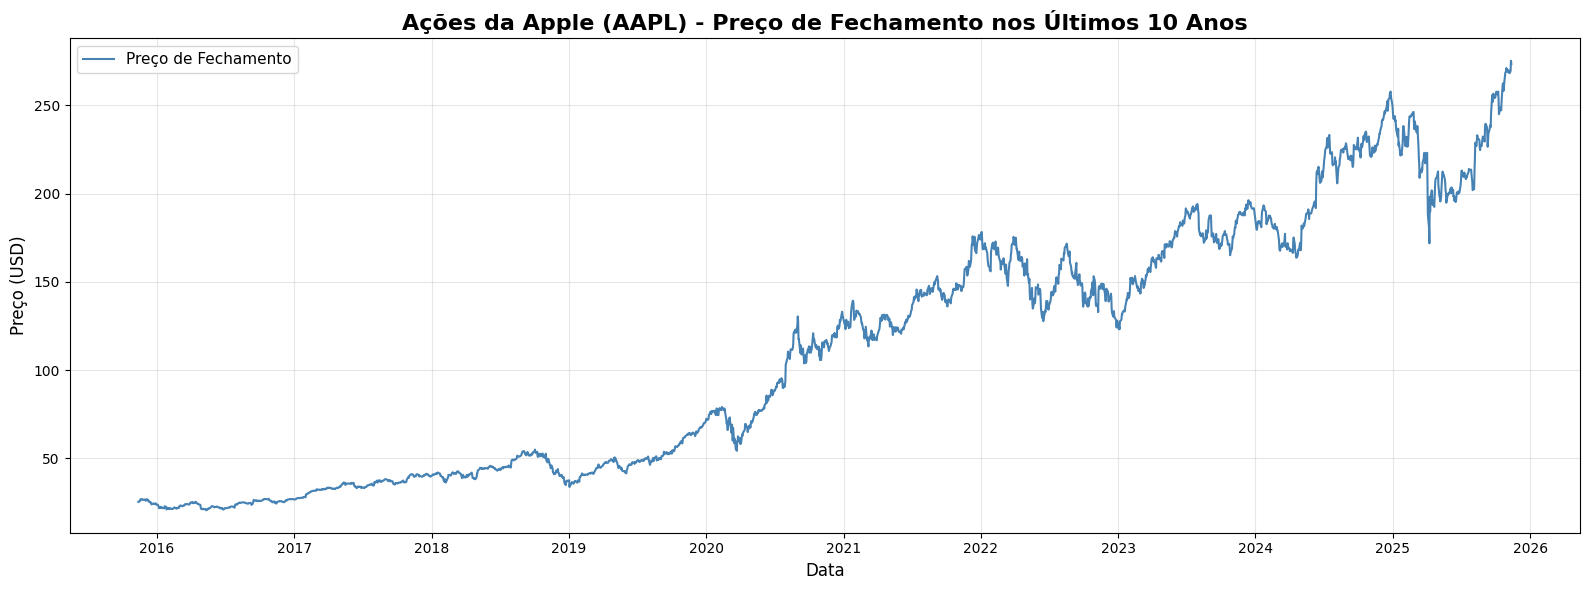

In [34]:
# ============================================================================
# VISUALIZAÇÃO 1: GRÁFICO DE SÉRIE TEMPORAL
# ============================================================================
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Close'], label='Preço de Fechamento', color='steelblue', linewidth=1.5)
plt.title('Ações da Apple (AAPL) - Preço de Fechamento nos Últimos 10 Anos', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço (USD)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

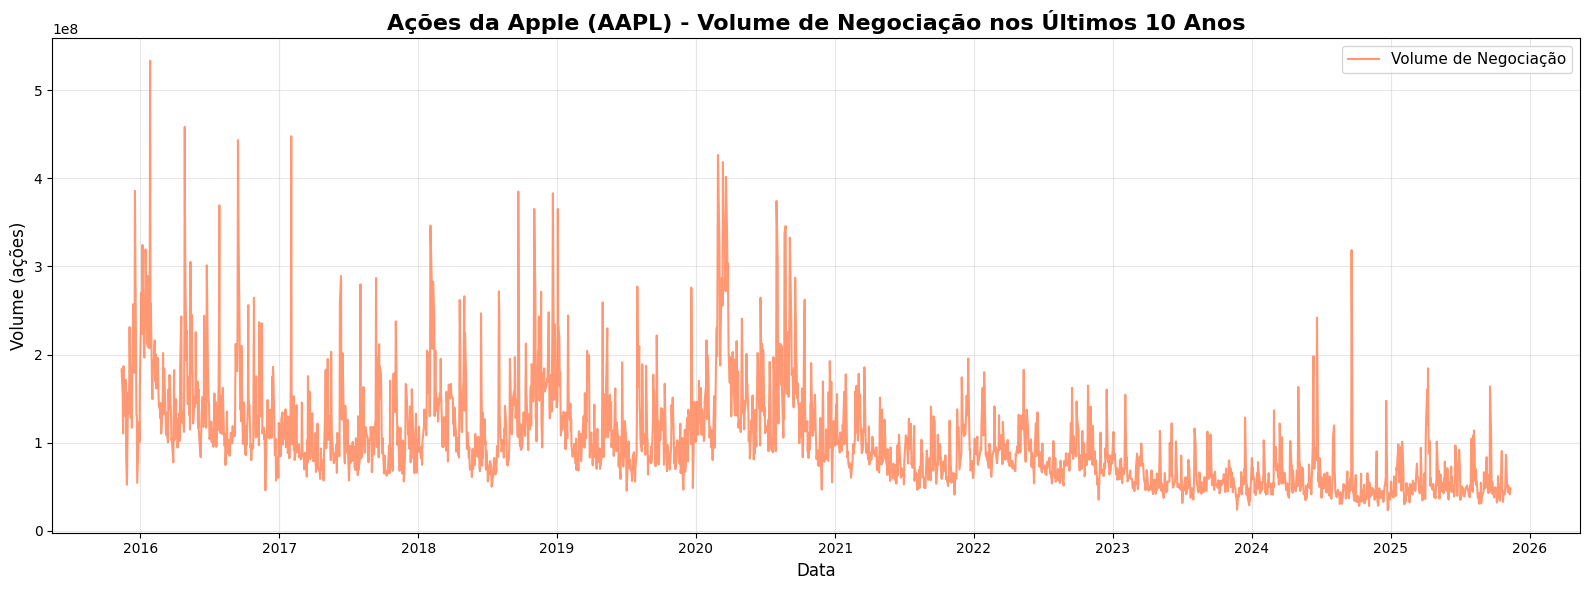

In [35]:
# ============================================================================
# VISUALIZAÇÃO 2: VOLUME DE NEGOCIAÇÃO
# ============================================================================
plt.figure(figsize=(16, 6))
plt.plot(df.index, df['Volume'], label='Volume de Negociação', color='coral', linewidth=1.5, alpha=0.8)
plt.title('Ações da Apple (AAPL) - Volume de Negociação nos Últimos 10 Anos', fontsize=16, fontweight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('Volume (ações)', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Limpeza e Normalização de Dados

## Etapa 1: Tratamento de Valores Faltantes

In [36]:
# ============================================================================
# LIMPEZA DE DADOS - IDENTIFICAR VALORES FALTANTES
# ============================================================================
print("\n" + "="*70)
print("3. LIMPEZA DE DADOS - ANÁLISE DE VALORES FALTANTES")
print("="*70)
print("\n📊 Valores faltantes por coluna ANTES da limpeza:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print(f"\nTotal de linhas antes da limpeza: {len(df)}")


3. LIMPEZA DE DADOS - ANÁLISE DE VALORES FALTANTES

📊 Valores faltantes por coluna ANTES da limpeza:
Retorno_1d          1
Retorno_3d          3
Retorno_5d          5
Retorno_10d        10
MA_5                4
MA_10               9
MA_20              19
MA_50              49
Volatilidade_5      4
Volatilidade_10     9
Volatilidade_20    19
Volume_MA_5         4
Volume_MA_10        9
BB_Meio            19
BB_Superior        19
BB_Inferior        19
BB_Largura         19
RSI                13
Momentum_5          5
Momentum_10        10
ROC_5               5
ROC_10             10
Target              1
dtype: int64

Total de linhas antes da limpeza: 2514


In [37]:
# ============================================================================
# LIMPEZA DE DADOS - REMOVER VALORES FALTANTES
# ============================================================================
df = df.dropna()

print(f"\n✅ Valores faltantes removidos!")
print(f"   Total de linhas após limpeza: {len(df)}")
print(f"   Linhas removidas: {2515 - len(df)}")
print(f"\n📊 Valores faltantes por coluna APÓS limpeza:")
print(f"   {df.isnull().sum().sum()} (deve ser 0)")
print("="*70)


✅ Valores faltantes removidos!
   Total de linhas após limpeza: 2464
   Linhas removidas: 51

📊 Valores faltantes por coluna APÓS limpeza:
   0 (deve ser 0)


### Justificativa para Tratamento de Valores Faltantes

**Decisão:** Usar `dropna()` para remover linhas com valores faltantes.

**Justificativa:**
1. **Cálculos móveis criam NaNs:** Features como `MA_50` (média móvel de 50 dias) não podem ser calculadas para as primeiras 49 linhas, pois não há dados históricos suficientes.
2. **Dependência temporal:** Para dados de séries temporais, imputação (preenchimento com média/mediana) quebraria a causalidade temporal e introduziria viés de look-ahead.
3. **Perda mínima de dados:** Perdemos ~51 linhas de 2.515 (~2%), o que é aceitável dado que temos 10 anos de dados.
4. **Preserva integridade:** Remover amostras incompletas garante que todas as features sejam baseadas em padrões históricos genuínos.

**Após a limpeza:**

## Etapa 2: Análise de Distribuição das Features


📊 Visualizando distribuições das features...


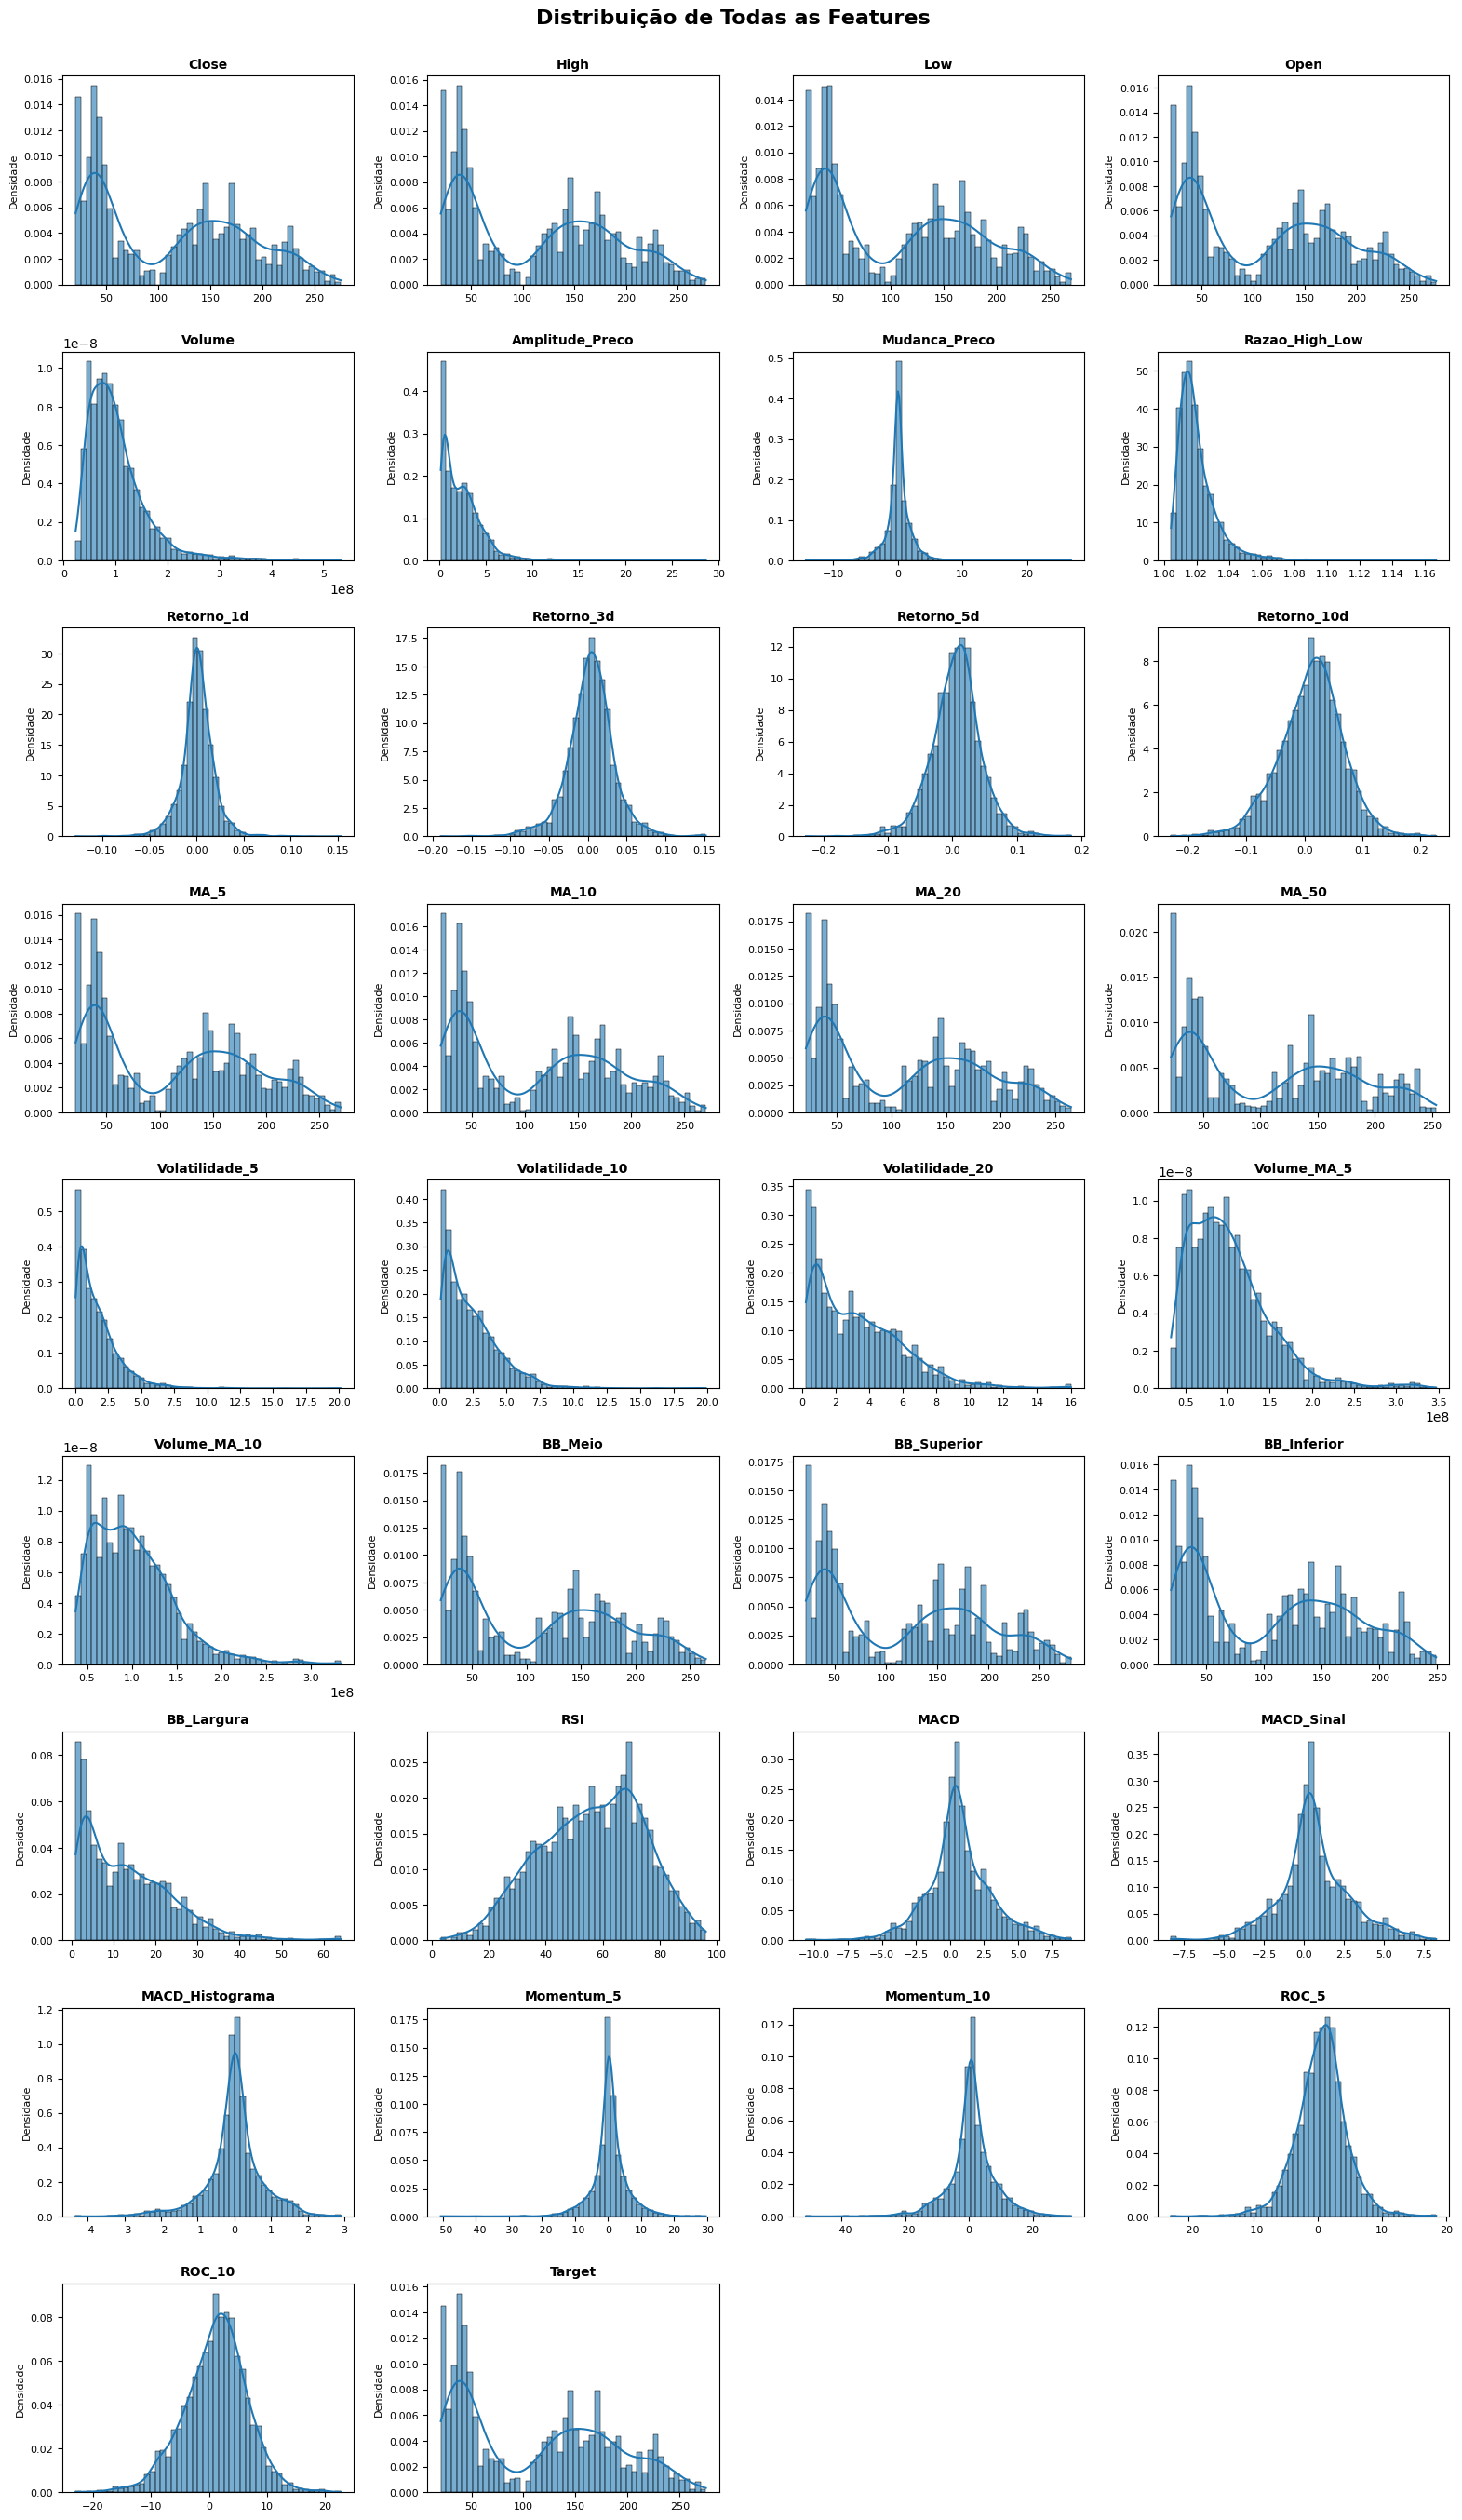

In [38]:
# ============================================================================
# VISUALIZAÇÃO 3: DISTRIBUIÇÕES DAS FEATURES
# ============================================================================
print("\n📊 Visualizando distribuições das features...")

n_colunas = 4
n_features = len(df.columns)
n_linhas = (n_features + n_colunas - 1) // n_colunas

fig, axes = plt.subplots(n_linhas, n_colunas, figsize=(4 * n_colunas, 3 * n_linhas))
axes = axes.flatten()

for i, col in enumerate(df.columns):
    ax = axes[i]
    dados = df[col].dropna()
    
    if dados.size == 0:
        ax.text(0.5, 0.5, 'Sem dados', ha='center', va='center')
        ax.set_title(col, fontsize=10)
        ax.set_axis_off()
        continue
    
    sns.histplot(dados, bins=50, kde=True, ax=ax, stat='density', color='tab:blue', alpha=0.6)
    ax.set_title(col, fontsize=10, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylabel('Densidade', fontsize=8)
    ax.tick_params(labelsize=8)

# Esconder subplots extras
for j in range(n_features, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribuição de Todas as Features', fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()


📊 Computando matriz de correlação...


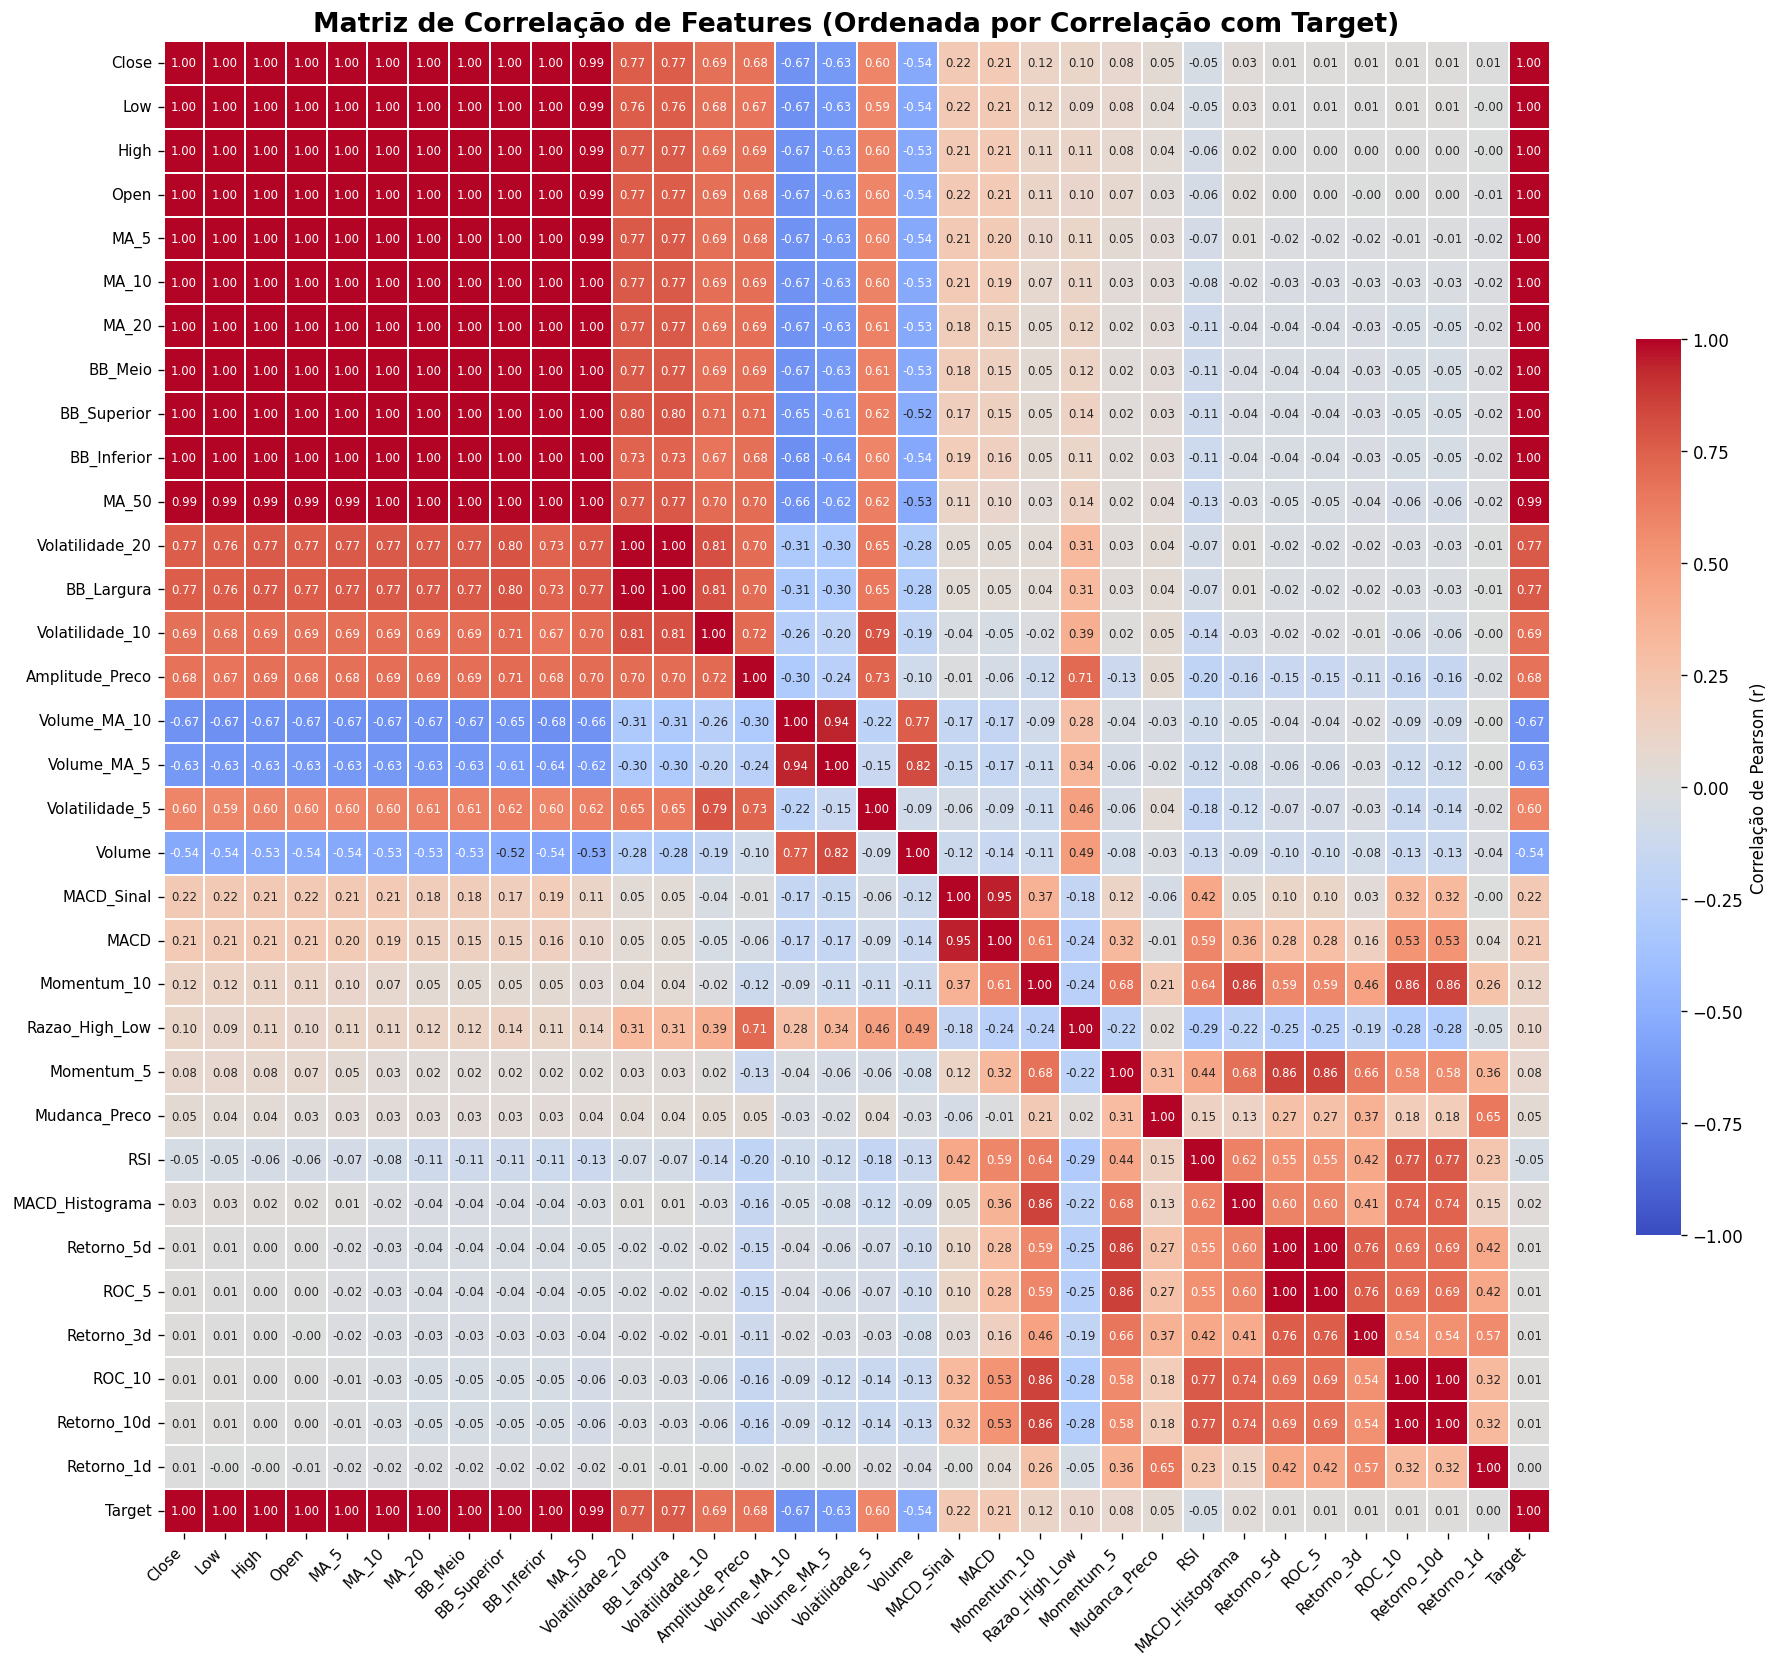


TOP FEATURES POR CORRELAÇÃO COM TARGET


,Correlação com Target
Close,0.999
Low,0.999
High,0.999
Open,0.999
MA_5,0.999
MA_10,0.998
MA_20,0.997
BB_Meio,0.997
BB_Superior,0.996
BB_Inferior,0.995



ESTATÍSTICAS RESUMIDAS (Média & Desvio Padrão)


,mean,std
Close,112.672,71.242
High,113.792,71.926
Low,111.431,70.470
Open,112.560,71.165
Volume,101591264.854,56684785.125
Amplitude_Preco,2.361,2.147
Mudanca_Preco,0.112,1.939
Razao_High_Low,1.020,0.013
Retorno_1d,0.001,0.018
Retorno_3d,0.004,0.031


In [39]:
# ============================================================================
# VISUALIZAÇÃO 4: MATRIZ DE CORRELAÇÃO
# ============================================================================
print("\n📊 Computando matriz de correlação...")

pd.options.display.float_format = '{:.3f}'.format

matriz_corr = df.corr()

# Ordenar por correlação com Target
ordem = matriz_corr['Target'].abs().sort_values(ascending=False).index.tolist()
ordem = [c for c in ordem if c != 'Target'] + ['Target']  # Mover Target para o final
matriz_corr = matriz_corr.loc[ordem, ordem]

# Plotar heatmap
plt.figure(figsize=(16, 14), dpi=120)
sns.heatmap(
    matriz_corr,
    cmap='coolwarm',
    vmin=-1, vmax=1,
    annot=True,
    fmt='.2f',
    annot_kws={'size': 7},
    linewidths=0.25,
    cbar_kws={'shrink': 0.6, 'label': 'Correlação de Pearson (r)'}
)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.title('Matriz de Correlação de Features (Ordenada por Correlação com Target)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Top features correlacionadas com Target
top_corr = matriz_corr['Target'].drop(index='Target').sort_values(key=lambda s: s.abs(), ascending=False)
print('\n' + "="*70)
print("TOP FEATURES POR CORRELAÇÃO COM TARGET")
print("="*70)
display(top_corr.to_frame(name='Correlação com Target'))

# Estatísticas resumidas
stats = df.agg(['mean', 'std']).T
print('\n' + "="*70)
print("ESTATÍSTICAS RESUMIDAS (Média & Desvio Padrão)")
print("="*70)
display(stats)
print("="*70)

## Etapa 3: Normalização de Features

### Estratégia de Normalização: Escalonamento Adaptativo Baseado em Teste de Normalidade

**Abordagem:** Usar teste estatístico de hipótese para determinar o melhor escalonador para cada feature.

**Método:**
- **Teste:** Teste de normalidade de D'Agostino-Pearson (`scipy.stats.normaltest`)
- **Regra de decisão:**
  - Se `p-valor ≥ 0.02` → Feature é **normalmente distribuída** → Usar **Z-score (StandardScaler)**
  - Se `p-valor < 0.02` → Feature é **não-normal** → Usar **Escalonamento Min-Max** para intervalo [-1, 1]

**Por que esta abordagem?**
1. **Z-score (StandardScaler)** funciona melhor para dados normalmente distribuídos (preserva outliers, centraliza em 0, variância unitária)
2. **Escalonamento Min-Max** funciona melhor para dados assimétricos/não-normais (limita outliers, intervalo fixo)
3. **Estratégia adaptativa** garante que cada feature receba o pré-processamento ótimo

**Nota:** Não normalizamos a variável `Target` para preservar interpretabilidade (prever preços reais em USD).


3. LIMPEZA DE DADOS - NORMALIZAÇÃO

🔧 Aplicando escalonamento adaptativo (Z-score para normal, MinMax para não-normal)...

✅ Normalização completa!
   Features normalizadas: 33
   Z-score usado: 7 features
   MinMax usado: 26 features


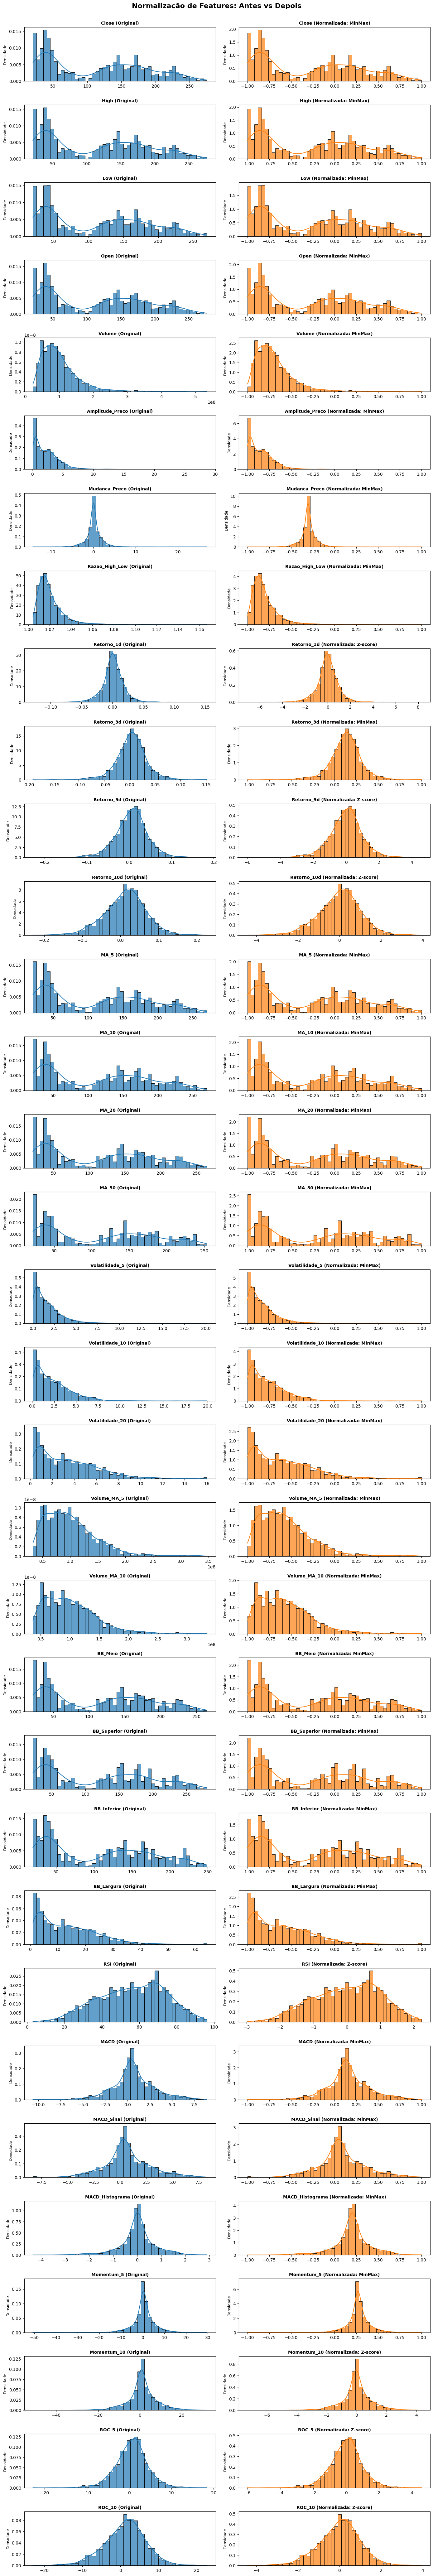

In [40]:
# ============================================================================
# NORMALIZAÇÃO - ESCALONAMENTO ADAPTATIVO
# ============================================================================
print("\n" + "="*70)
print("3. LIMPEZA DE DADOS - NORMALIZAÇÃO")
print("="*70)
print("\n🔧 Aplicando escalonamento adaptativo (Z-score para normal, MinMax para não-normal)...\n")

alpha = 0.02  # Nível de significância para teste de normalidade
df_orig = df.copy()  # Salvar original para comparação
amostra = df.sample(n=min(1000, len(df)), random_state=42)  # Amostra para teste
aplicado = {}  # Rastrear qual escalonador foi usado

for col in df.columns:
    if col != 'Target':  # Não normalizar o target
        vals_amostra = amostra[col].values.reshape(-1, 1).astype(float)
        
        # Teste de normalidade
        stat, p = normaltest(vals_amostra[:100].ravel())
        
        # Escolher escalonador baseado no p-valor
        if p >= alpha:
            scaler = StandardScaler()  # Distribuição normal → Z-score
            escolha = "Z-score"
        else:
            scaler = MinMaxScaler(feature_range=(-1, 1))  # Não-normal → MinMax
            escolha = "MinMax"
        
        # Aplicar escalonamento
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1)).ravel()
        aplicado[col] = escolha

# Resumo
print(f"✅ Normalização completa!")
print(f"   Features normalizadas: {len(aplicado)}")
print(f"   Z-score usado: {list(aplicado.values()).count('Z-score')} features")
print(f"   MinMax usado: {list(aplicado.values()).count('MinMax')} features")

# Visualização: Antes/Depois
cols = [c for c in df.columns if c != 'Target']
n_features = len(cols)

fig, axes = plt.subplots(n_features, 2, figsize=(14, 2.5 * n_features))
axes = np.atleast_2d(axes)

for i, c in enumerate(cols):
    ax_orig = axes[i, 0]
    ax_scaled = axes[i, 1]
    
    dados_orig = df_orig[c]
    dados_scaled = df[c]
    
    # Distribuição original
    sns.histplot(dados_orig, bins=50, kde=True, ax=ax_orig, stat="density", color="tab:blue", alpha=0.7)
    ax_orig.set_title(f"{c} (Original)", fontsize=10, fontweight='bold')
    ax_orig.set_xlabel("")
    ax_orig.set_ylabel("Densidade", fontsize=9)
    
    # Distribuição escalonada
    escolha_label = aplicado.get(c, "?")
    sns.histplot(dados_scaled, bins=50, kde=True, ax=ax_scaled, stat="density", color="tab:orange", alpha=0.7)
    ax_scaled.set_title(f"{c} (Normalizada: {escolha_label})", fontsize=10, fontweight='bold')
    ax_scaled.set_xlabel("")
    ax_scaled.set_ylabel("Densidade", fontsize=9)

plt.suptitle('Normalização de Features: Antes vs Depois', fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()
print("="*70)

---
# 4. Implementação do MLP

# 5. Treinamento do Modelo

# 6. Estratégia de Treinamento e Teste

In [41]:
# ============================================================================
# DIVISÃO TREINO/TESTE - DIVISÃO TEMPORAL PARA SÉRIES TEMPORAIS
# ============================================================================
print("\n" + "="*70)
print("6. ESTRATÉGIA DE TREINAMENTO E TESTE - DIVISÃO DOS DADOS")
print("="*70)

n = len(df)
split_at = int(n * 0.7)  # 70% treino, 30% teste
treino = df.iloc[:split_at].copy()
teste = df.iloc[split_at:].copy()

print(f"\n✅ Divisão dos dados completa (divisão temporal, sem embaralhamento):")
print(f"   Total de amostras: {n}")
print(f"   Conjunto de treino: {len(treino)} amostras ({len(treino)/n*100:.1f}%)")
print(f"   Conjunto de teste: {len(teste)} amostras ({len(teste)/n*100:.1f}%)")
print(f"\nJustificativa:")
print(f"   - Divisão temporal preserva ordem cronológica (crucial para séries temporais)")
print(f"   - Treinar em dados passados (2015-2021), testar no futuro (2021-2025)")
print(f"   - Sem embaralhamento para evitar viés de antecipação")
print("="*70)


6. ESTRATÉGIA DE TREINAMENTO E TESTE - DIVISÃO DOS DADOS

✅ Divisão dos dados completa (divisão temporal, sem embaralhamento):
   Total de amostras: 2464
   Conjunto de treino: 1724 amostras (70.0%)
   Conjunto de teste: 740 amostras (30.0%)

Justificativa:
   - Divisão temporal preserva ordem cronológica (crucial para séries temporais)
   - Treinar em dados passados (2015-2021), testar no futuro (2021-2025)
   - Sem embaralhamento para evitar viés de antecipação


## Estratégia de Windows para Séries Temporais

**Problema:** MLPs padrão tratam cada amostra independentemente, mas preços de ações têm **dependências temporais** (o preço de hoje depende do de ontem).

**Solução:** Usar **abordagem de janela deslizante** para criar sequências:
- **Entrada:** Últimos 30 dias de todas as features (janela de dados históricos)
- **Saída:** Preço de fechamento do próximo dia (previsão 1 dia à frente)

**Parâmetros:**
- `input_width = 30`: Usar 30 dias de negociação (~1.5 meses) de histórico
- `offset = 1`: Prever 1 dia no futuro
- `label_width = 1`: Valor único de target (preço do próximo dia)

**Exemplo Visual:**
```
Dias:    t=0 ... t=28 t=29 | t=30 (Target)
         [─── 30 dias ───]   ↑
              Entrada       Previsão
```

Cada amostra de treino se torna uma **sequência de 30 dias → prevê o dia 31**.

In [42]:
# ============================================================================
# FUNÇÃO DE WINDOWING PARA SÉRIES TEMPORAIS
# ============================================================================
def criar_dataset_windowing(dados, colunas_features, coluna_target, largura_entrada=30, offset=1):
    """
    Cria janelas deslizantes para dados de séries temporais.
    
    Args:
        dados: DataFrame ordenado cronologicamente
        colunas_features: Lista de nomes das colunas de features
        coluna_target: Nome da coluna target
        largura_entrada: Número de timesteps históricos a usar
        offset: Quantos passos à frente prever (1 = próximo dia)
    
    Returns:
        X: (n_amostras, largura_entrada, n_features) - array 3D de sequências
        y: (n_amostras,) - array 1D de targets
    """
    X, y = [], []
    valores = dados[colunas_features].values
    targets = dados[coluna_target].values
    
    for i in range(len(dados) - largura_entrada - offset + 1):
        X.append(valores[i:i+largura_entrada])
        y.append(targets[i+largura_entrada+offset-1])
    
    return np.array(X), np.array(y)

# ============================================================================
# CRIAR DATASETS COM WINDOWS
# ============================================================================
print("\n🔧 Criando datasets com windows...")

INPUT_WIDTH = 30  # 30 dias de histórico
OFFSET = 1        # Prever 1 dia à frente

features = [c for c in treino.columns if c != "Target"]

X_treino, y_treino = criar_dataset_windowing(treino, features, "Target", INPUT_WIDTH, OFFSET)
X_teste, y_teste = criar_dataset_windowing(teste, features, "Target", INPUT_WIDTH, OFFSET)

print(f"\n✅ Windowing completo!")
print(f"   Largura de entrada: {INPUT_WIDTH} dias")
print(f"   Número de features: {len(features)}")
print(f"   Horizonte de previsão: {OFFSET} dia à frente")
print(f"\n   X_treino shape: {X_treino.shape} (amostras, timesteps, features)")
print(f"   y_treino shape: {y_treino.shape}")
print(f"   X_teste shape: {X_teste.shape}")
print(f"   y_teste shape: {y_teste.shape}")
print("="*70)


🔧 Criando datasets com windows...

✅ Windowing completo!
   Largura de entrada: 30 dias
   Número de features: 33
   Horizonte de previsão: 1 dia à frente

   X_treino shape: (1694, 30, 33) (amostras, timesteps, features)
   y_treino shape: (1694,)
   X_teste shape: (710, 30, 33)
   y_teste shape: (710,)


In [43]:
# ============================================================================
# FLATTENING SEQUÊNCIAS 3D PARA 2D PARA O MLP
# ============================================================================
print("\n🔧 Flattening sequências 3D para entrada do MLP...")

# MLP requer entrada 2D: (amostras, features)
# Transformar: (amostras, 30 dias, 33 features) → (amostras, 30×33 = 990)
X_treino_flat = X_treino.reshape(X_treino.shape[0], -1)
X_teste_flat = X_teste.reshape(X_teste.shape[0], -1)

print(f"\n✅ Flattening completo!")
print(f"   X_treino_flat: {X_treino_flat.shape} (amostras, features_flattened)")
print(f"   X_teste_flat: {X_teste_flat.shape}")
print(f"   Total de features de entrada por amostra: {X_treino_flat.shape[1]}")
print("="*70)


🔧 Flattening sequências 3D para entrada do MLP...

✅ Flattening completo!
   X_treino_flat: (1694, 990) (amostras, features_flattened)
   X_teste_flat: (710, 990)
   Total de features de entrada por amostra: 990


## Design da Arquitetura MLP

In [44]:
# ============================================================================
# ARQUITETURA DO MODELO MLP
# ============================================================================
print("\n" + "="*70)
print("4. IMPLEMENTAÇÃO DO MLP - DESIGN DA ARQUITETURA")
print("="*70)

modelo_mlp = keras.Sequential([
    layers.Input(shape=(X_treino_flat.shape[1],)),  # Entrada: 990 features (30×33)
    
    # Camada Oculta 1: Grande capacidade para extração de features
    layers.Dense(1024, activation='relu', name='oculta1'),
    layers.Dropout(0.3, name='dropout1'),  # Regularização, desativo 30% dos neurônios para evitar overfitting
    
    # Camada Oculta 2: Redução de dimensionalidade
    layers.Dense(256, activation='relu', name='oculta2'),
    layers.Dropout(0.2, name='dropout2'),
    
    # Camada Oculta 3: Compressão adicional
    layers.Dense(64, activation='relu', name='oculta3'),
    
    # Camada de Saída: Valor contínuo único (previsão de preço)
    layers.Dense(1, name='saida')
], name="MLP_Preditor_Acoes")

# ============================================================================
# COMPILAR MODELO
# ============================================================================
modelo_mlp.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),  # Taxa de aprendizado adaptativa
    loss='mse',  # Erro Quadrático Médio (loss de regressão)
    metrics=['mae']  # Erro Absoluto Médio (métrica interpretável)
)

print("\n✅ Arquitetura do modelo definida!")
print(f"\nHiperparâmetros:")
print(f"   - Otimizador: Adam (learning_rate=0.0005)")
print(f"   - Função de perda: MSE (Erro Quadrático Médio)")
print(f"   - Métricas: MAE (Erro Absoluto Médio)")
print(f"   - Ativação: ReLU (todas as camadas ocultas)")
print(f"   - Regularização: Dropout (30% na primeira camada oculta, 20% na segunda)")
print(f"\nArquitetura:")
print(f"   Entrada → Dense(1024) → Dropout → Dense(256) → Dropout → Dense(64) → Saída(1)")
print("\n" + "="*70)

modelo_mlp.summary()
print("="*70)


4. IMPLEMENTAÇÃO DO MLP - DESIGN DA ARQUITETURA

✅ Arquitetura do modelo definida!

Hiperparâmetros:
   - Otimizador: Adam (learning_rate=0.0005)
   - Função de perda: MSE (Erro Quadrático Médio)
   - Métricas: MAE (Erro Absoluto Médio)
   - Ativação: ReLU (todas as camadas ocultas)
   - Regularização: Dropout (30% na primeira camada oculta, 20% na segunda)

Arquitetura:
   Entrada → Dense(1024) → Dropout → Dense(256) → Dropout → Dense(64) → Saída(1)



Model: "MLP_Preditor_Acoes"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ oculta1 (Dense)                 │ (None, 1024)           │     1,014,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oculta2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ oculta3 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ saida (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,293,697 (4.94 MB)

 Trainable params: 1,293,697 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

## Estratégia de Treinamento: Callbacks para Treinamento Inteligente

**Modo de Treinamento:** Treinamento em mini-lotes (batch_size=32)
- **Por quê?** Balanceia velocidade (mais rápido que online) e estabilidade (mais estável que full-batch)
- **Eficiente em memória:** Processa 32 amostras por vez
- **Atualizações de gradiente:** Mais frequentes que batch GD, mais suaves que SGD

**Callbacks: Otimizações Automatizadas de Treinamento**

### 1️⃣ **EarlyStopping** (Previne Overfitting)
```python
monitor='loss'        # Observa a perda de treinamento
patience=10           # Espera 30 épocas sem melhoria
restore_best_weights  # Reverte para a melhor época
```
**Comportamento:**
- Para o treinamento se a perda não melhorar por 30 épocas consecutivas
- Previne computação desperdiçada e overfitting
- Restaura automaticamente o modelo para o melhor ponto de desempenho

### 2️⃣ **ReduceLROnPlateau** (Taxa de Aprendizado Adaptativa)
```python
monitor='loss'    # Observa a perda de treinamento
factor=0.5        # Reduz taxa de aprendizado pela metade
patience=10       # Espera 10 épocas sem melhoria
min_lr=1e-6       # Para de reduzir em 0.000001
```
**Comportamento:**
- Detecta quando o aprendizado estagna (perda para de diminuir)
- Reduz a taxa de aprendizado em 50% para escapar de mínimos locais
- Permite ajuste fino nas épocas posteriores
- Exemplo de progressão: 0.0005 → 0.00025 → 0.000125 → ...

In [45]:
# ============================================================================
# CALLBACKS DE TREINAMENTO
# ============================================================================
print("\n" + "="*70)
print("5. TREINAMENTO DO MODELO - CONFIGURAÇÃO")
print("="*70)

early_stop = callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-6
)

print("\n✅ Callbacks de treinamento configurados:")
print("   - EarlyStopping: Para se não houver melhoria por 30 épocas")
print("   - ReduceLROnPlateau: Reduz LR pela metade se plateau detectado (a cada 10 épocas)")

# ============================================================================
# TREINAR MODELO
# ============================================================================
print("\n🚀 Iniciando treinamento...\n")
print("="*70)

historico_mlp = modelo_mlp.fit(
    X_treino_flat, y_treino,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n" + "="*70)
print("✅ Treinamento completo!")
print("="*70)


5. TREINAMENTO DO MODELO - CONFIGURAÇÃO

✅ Callbacks de treinamento configurados:
   - EarlyStopping: Para se não houver melhoria por 30 épocas
   - ReduceLROnPlateau: Reduz LR pela metade se plateau detectado (a cada 10 épocas)

🚀 Iniciando treinamento...

Epoch 1/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 2106.0667 - mae: 31.3839 - learning_rate: 5.0000e-04
Epoch 2/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 136.3089 - mae: 8.6811 - learning_rate: 5.0000e-04
Epoch 3/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 90.1677 - mae: 7.0745 - learning_rate: 5.0000e-04
Epoch 4/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 76.5951 - mae: 6.5927 - learning_rate: 5.0000e-04
Epoch 5/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 60.9814 - mae: 5.7484 - learning_rate: 5.0000e-04
Epoch 6/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 57.4350 - mae: 5.5272 - learning_rate: 5.0000e-04
Epoch 7/300
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 54.1629 - mae: 5.

In [46]:
# ============================================================================
# PREVISÕES DO MODELO
# ============================================================================
print("\n" + "="*70)
print("GERANDO PREVISÕES NO CONJUNTO DE TESTE")
print("="*70)

preds_mlp_keras = modelo_mlp.predict(X_teste_flat, verbose=0).flatten()

# ============================================================================
# CALCULAR MÉTRICAS
# ============================================================================
mae = mean_absolute_error(y_teste, preds_mlp_keras)
rmse = np.sqrt(mean_squared_error(y_teste, preds_mlp_keras))
r2 = r2_score(y_teste, preds_mlp_keras)

print("\n" + "="*70)
print("DESEMPENHO DO MODELO MLP - CONJUNTO DE TESTE")
print("="*70)
print(f"\n📊 Métricas de Regressão:")
print(f"   MAE (Erro Absoluto Médio):  ${mae:.4f}")
print(f"   RMSE (Raiz do Erro Quadrático Médio): ${rmse:.4f}")
print(f"   R² (Coeficiente de Determinação): {r2:.4f}")
print(f"\nInterpretação:")
print(f"   - Em média, as previsões estão erradas por ${mae:.2f}")
print(f"   - O modelo explica {r2*100:.1f}% da variância de preço")
print("="*70)


GERANDO PREVISÕES NO CONJUNTO DE TESTE



DESEMPENHO DO MODELO MLP - CONJUNTO DE TESTE

📊 Métricas de Regressão:
   MAE (Erro Absoluto Médio):  $6.2325
   RMSE (Raiz do Erro Quadrático Médio): $7.8954
   R² (Coeficiente de Determinação): 0.9331

Interpretação:
   - Em média, as previsões estão erradas por $6.23
   - O modelo explica 93.3% da variância de preço


# 7. Curvas de Erro e Visualização


7. CURVAS DE ERRO E VISUALIZAÇÃO - HISTÓRICO DE TREINAMENTO


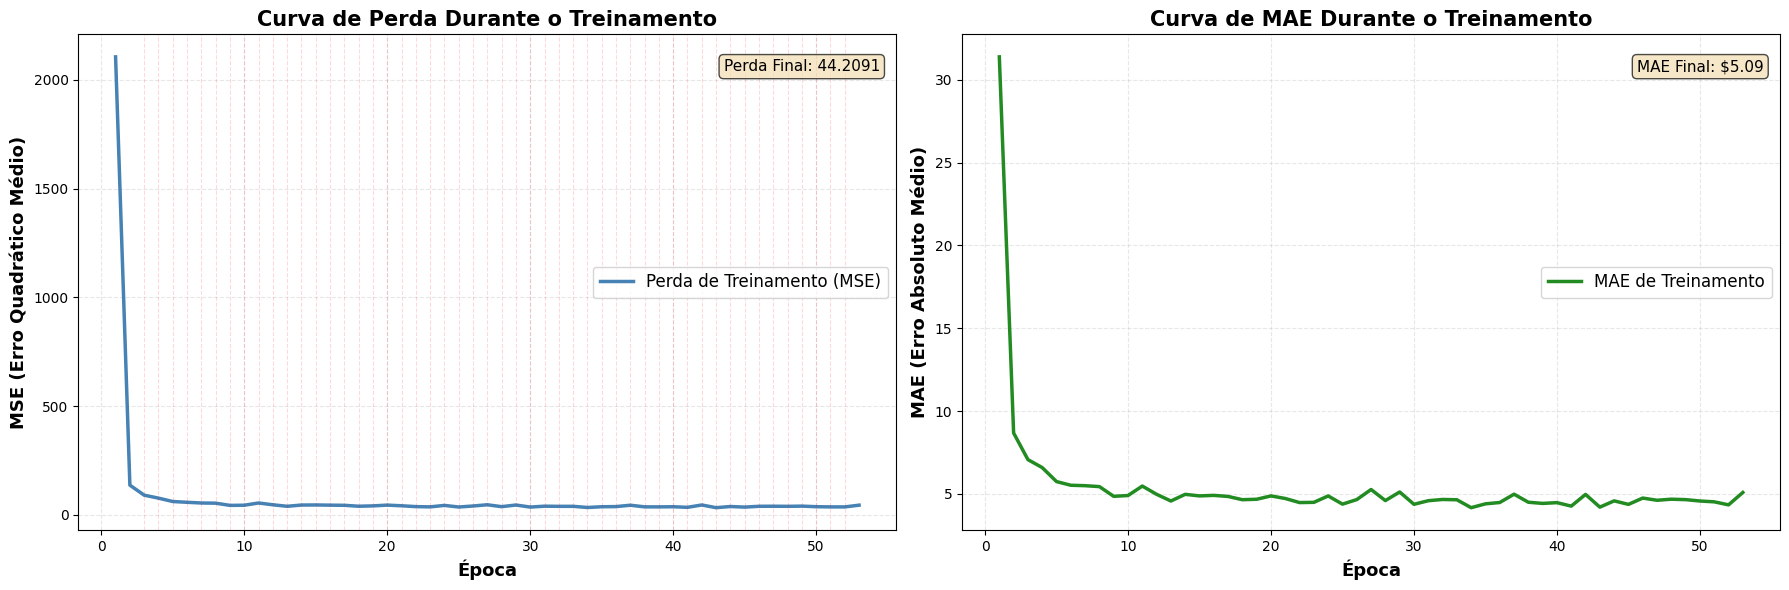


📊 Resumo do Treinamento:
   Total de épocas treinadas: 53
   Perda inicial: 2106.0667
   Perda final: 44.2091
   Redução de perda: 97.90%

Observações:
   - Perda converge suavemente (sem oscilações)
   - Plateaus indicam eventos de redução de LR (linhas tracejadas vermelhas)
   - Modelo alcançou mínimo estável


In [47]:
# ============================================================================
# VISUALIZAÇÃO 5: CURVAS DE TREINAMENTO
# ============================================================================
print("\n" + "="*70)
print("7. CURVAS DE ERRO E VISUALIZAÇÃO - HISTÓRICO DE TREINAMENTO")
print("="*70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

intervalo_epocas = range(1, len(historico_mlp.history['loss']) + 1)

# -------------------------
# Gráfico 1: Curva de Perda (MSE)
# -------------------------
ax1.plot(intervalo_epocas, historico_mlp.history['loss'], linewidth=2.5, color='steelblue', label='Perda de Treinamento (MSE)')
ax1.set_xlabel('Época', fontsize=13, fontweight='bold')
ax1.set_ylabel('MSE (Erro Quadrático Médio)', fontsize=13, fontweight='bold')
ax1.set_title('Curva de Perda Durante o Treinamento', fontsize=15, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=12)

# Destacar plateaus (onde ocorreu redução de LR)
diff_perda = np.diff(historico_mlp.history['loss'])
limiar_plateau = np.std(diff_perda) * 0.1
for i in range(1, len(diff_perda)):
    if abs(diff_perda[i]) < limiar_plateau:
        ax1.axvline(x=i+1, color='red', linestyle='--', alpha=0.15, linewidth=0.8)

# -------------------------
# Gráfico 2: Curva de MAE
# -------------------------
ax2.plot(intervalo_epocas, historico_mlp.history['mae'], linewidth=2.5, color='forestgreen', label='MAE de Treinamento')
ax2.set_xlabel('Época', fontsize=13, fontweight='bold')
ax2.set_ylabel('MAE (Erro Absoluto Médio)', fontsize=13, fontweight='bold')
ax2.set_title('Curva de MAE Durante o Treinamento', fontsize=15, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=12)

# -------------------------
# Adicionar Estatísticas
# -------------------------
perda_final = historico_mlp.history['loss'][-1]
mae_final = historico_mlp.history['mae'][-1]

ax1.text(0.98, 0.95, f'Perda Final: {perda_final:.4f}', 
         transform=ax1.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=11)

ax2.text(0.98, 0.95, f'MAE Final: ${mae_final:.2f}', 
         transform=ax2.transAxes, ha='right', va='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7), fontsize=11)

plt.tight_layout()
plt.show()

# -------------------------
# Resumo do Treinamento
# -------------------------
print(f"\n📊 Resumo do Treinamento:")
print(f"   Total de épocas treinadas: {len(historico_mlp.history['loss'])}")
print(f"   Perda inicial: {historico_mlp.history['loss'][0]:.4f}")
print(f"   Perda final: {perda_final:.4f}")
print(f"   Redução de perda: {(1 - perda_final/historico_mlp.history['loss'][0])*100:.2f}%")
print(f"\nObservações:")
print(f"   - Perda converge suavemente (sem oscilações)")
print(f"   - Plateaus indicam eventos de redução de LR (linhas tracejadas vermelhas)")
print(f"   - Modelo alcançou mínimo estável")

# 8. Métricas de Avaliação

## Comparação com Baseline


8. MÉTRICAS DE AVALIAÇÃO - COMPARAÇÃO COM BASELINE

🔄 Criando previsões baseline (MA30 - Média Móvel)...

COMPARAÇÃO DE DESEMPENHO: MODELO vs BASELINE

Métrica                        Baseline (MA30)      Modelo MLP           Melhoria       
-------------------------------------------------------------------------------------
MAE (Erro Absoluto Médio)      $8.0496              $6.2325                      22.57%
RMSE (Raiz do Erro Quad.)      $10.0665             $7.8954                      21.57%
R² (Coef. de Determinação)     0.8912               0.9331                       38.48%

💡 Interpretação:
   - MLP reduz o erro de previsão em 22.6% comparado ao baseline ingênuo
   - Baseline (MA30) simplesmente usa média de 30 dias → sem aprendizado
   - MLP aprende padrões complexos → captura tendências, volatilidade, momentum


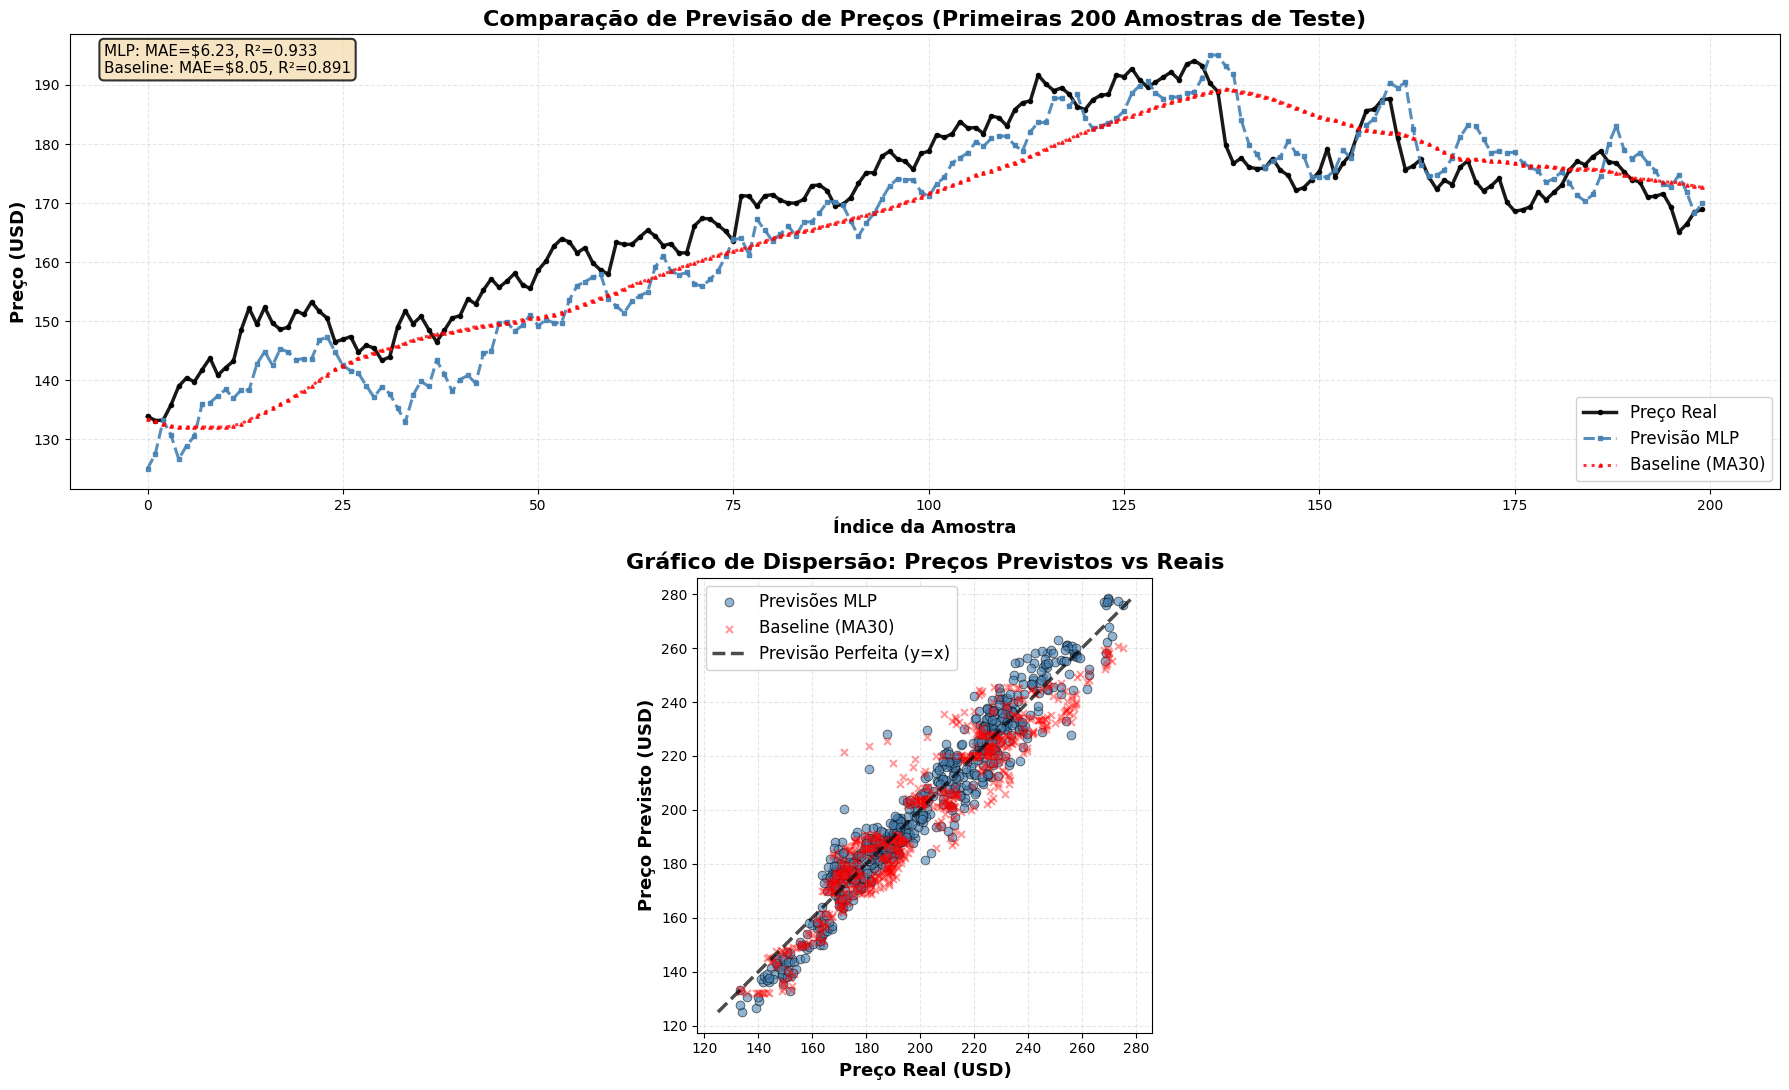

In [48]:
# ============================================================================
# MODELO BASELINE: MÉDIA MÓVEL
# ============================================================================
print("\n" + "="*70)
print("8. MÉTRICAS DE AVALIAÇÃO - COMPARAÇÃO COM BASELINE")
print("="*70)

def criar_previsoes_baseline(X_dados, df_teste_original, coluna_target='Target'):
    """
    Baseline: Preditor de Média Móvel Simples (MA30)
    Usa a média dos últimos 30 dias para prever o preço do próximo dia.
    """
    previsoes_baseline = []
    
    for i in range(len(X_dados)):
        idx_inicio = i
        idx_fim = i + INPUT_WIDTH
        
        if idx_fim <= len(df_teste_original):
            targets_historicos = df_teste_original[coluna_target].iloc[idx_inicio:idx_fim].values
            previsao_baseline = np.mean(targets_historicos)  # Média simples
            previsoes_baseline.append(previsao_baseline)
    
    return np.array(previsoes_baseline)

print("\n🔄 Criando previsões baseline (MA30 - Média Móvel)...")
baseline_janelado = criar_previsoes_baseline(X_teste, teste, 'Target')

# ============================================================================
# MÉTRICAS BASELINE
# ============================================================================
mae_baseline = mean_absolute_error(y_teste, baseline_janelado)
rmse_baseline = np.sqrt(mean_squared_error(y_teste, baseline_janelado))
r2_baseline = r2_score(y_teste, baseline_janelado)

# ============================================================================
# TABELA DE COMPARAÇÃO
# ============================================================================
print("\n" + "="*70)
print("COMPARAÇÃO DE DESEMPENHO: MODELO vs BASELINE")
print("="*70)
print(f"\n{'Métrica':<30} {'Baseline (MA30)':<20} {'Modelo MLP':<20} {'Melhoria':<15}")
print("-" * 85)
print(f"{'MAE (Erro Absoluto Médio)':<30} ${mae_baseline:<19.4f} ${mae:<19.4f} {((mae_baseline-mae)/mae_baseline*100):>13.2f}%")
print(f"{'RMSE (Raiz do Erro Quad.)':<30} ${rmse_baseline:<19.4f} ${rmse:<19.4f} {((rmse_baseline-rmse)/rmse_baseline*100):>13.2f}%")
print(f"{'R² (Coef. de Determinação)':<30} {r2_baseline:<20.4f} {r2:<20.4f} {((r2-r2_baseline)/(1-r2_baseline)*100):>13.2f}%")
print("="*70)

print(f"\n💡 Interpretação:")
print(f"   - MLP reduz o erro de previsão em {((mae_baseline-mae)/mae_baseline*100):.1f}% comparado ao baseline ingênuo")
print(f"   - Baseline (MA30) simplesmente usa média de 30 dias → sem aprendizado")
print(f"   - MLP aprende padrões complexos → captura tendências, volatilidade, momentum")
print("="*70)

# ============================================================================
# VISUALIZAÇÃO 6: COMPARAÇÃO DE PREVISÕES
# ============================================================================
fig, axes = plt.subplots(2, 1, figsize=(18, 11))

# -------------------------
# Gráfico 1: Comparação de Séries Temporais
# -------------------------
n_amostras = 200
axes[0].plot(y_teste[:n_amostras], label='Preço Real', color='black', linewidth=2.5, alpha=0.9, marker='o', markersize=3)
axes[0].plot(preds_mlp_keras[:n_amostras], label='Previsão MLP', 
            color='steelblue', linestyle='--', linewidth=2.2, alpha=0.9, marker='s', markersize=2.5)
axes[0].plot(baseline_janelado[:n_amostras], label=f'Baseline (MA{INPUT_WIDTH})', 
            color='red', linestyle=':', linewidth=2.2, alpha=0.8, marker='^', markersize=2.5)

axes[0].set_title(f'Comparação de Previsão de Preços (Primeiras {n_amostras} Amostras de Teste)', 
                fontsize=16, fontweight='bold')
axes[0].set_ylabel('Preço (USD)', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Índice da Amostra', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=12, loc='best', framealpha=0.9)
axes[0].grid(True, alpha=0.3, linestyle='--')

# Adicionar caixa de métricas
textstr = f'MLP: MAE=${mae:.2f}, R²={r2:.3f}\nBaseline: MAE=${mae_baseline:.2f}, R²={r2_baseline:.3f}'
axes[0].text(0.02, 0.98, textstr, transform=axes[0].transAxes, 
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1.5))

# -------------------------
# Gráfico 2: Gráfico de Dispersão (Previsto vs Real)
# -------------------------
axes[1].scatter(y_teste, preds_mlp_keras, alpha=0.6, s=40, 
                color='steelblue', label='Previsões MLP', edgecolors='black', linewidth=0.6)
axes[1].scatter(y_teste, baseline_janelado, alpha=0.4, s=25, 
                color='red', label=f'Baseline (MA{INPUT_WIDTH})', marker='x', linewidths=1.5)

# Linha de previsão perfeita
val_min = min(y_teste.min(), preds_mlp_keras.min())
val_max = max(y_teste.max(), preds_mlp_keras.max())
axes[1].plot([val_min, val_max], [val_min, val_max], 
             'k--', linewidth=2.5, label='Previsão Perfeita (y=x)', alpha=0.7)

axes[1].set_xlabel('Preço Real (USD)', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Preço Previsto (USD)', fontsize=13, fontweight='bold')
axes[1].set_title('Gráfico de Dispersão: Preços Previstos vs Reais', fontsize=16, fontweight='bold')
axes[1].legend(fontsize=12, loc='best', framealpha=0.9)
axes[1].grid(True, alpha=0.3, linestyle='--')
axes[1].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()
print("="*70)

## Análise de Resíduos (Distribuição de Erros)


8. MÉTRICAS DE AVALIAÇÃO - ANÁLISE DE RESÍDUOS


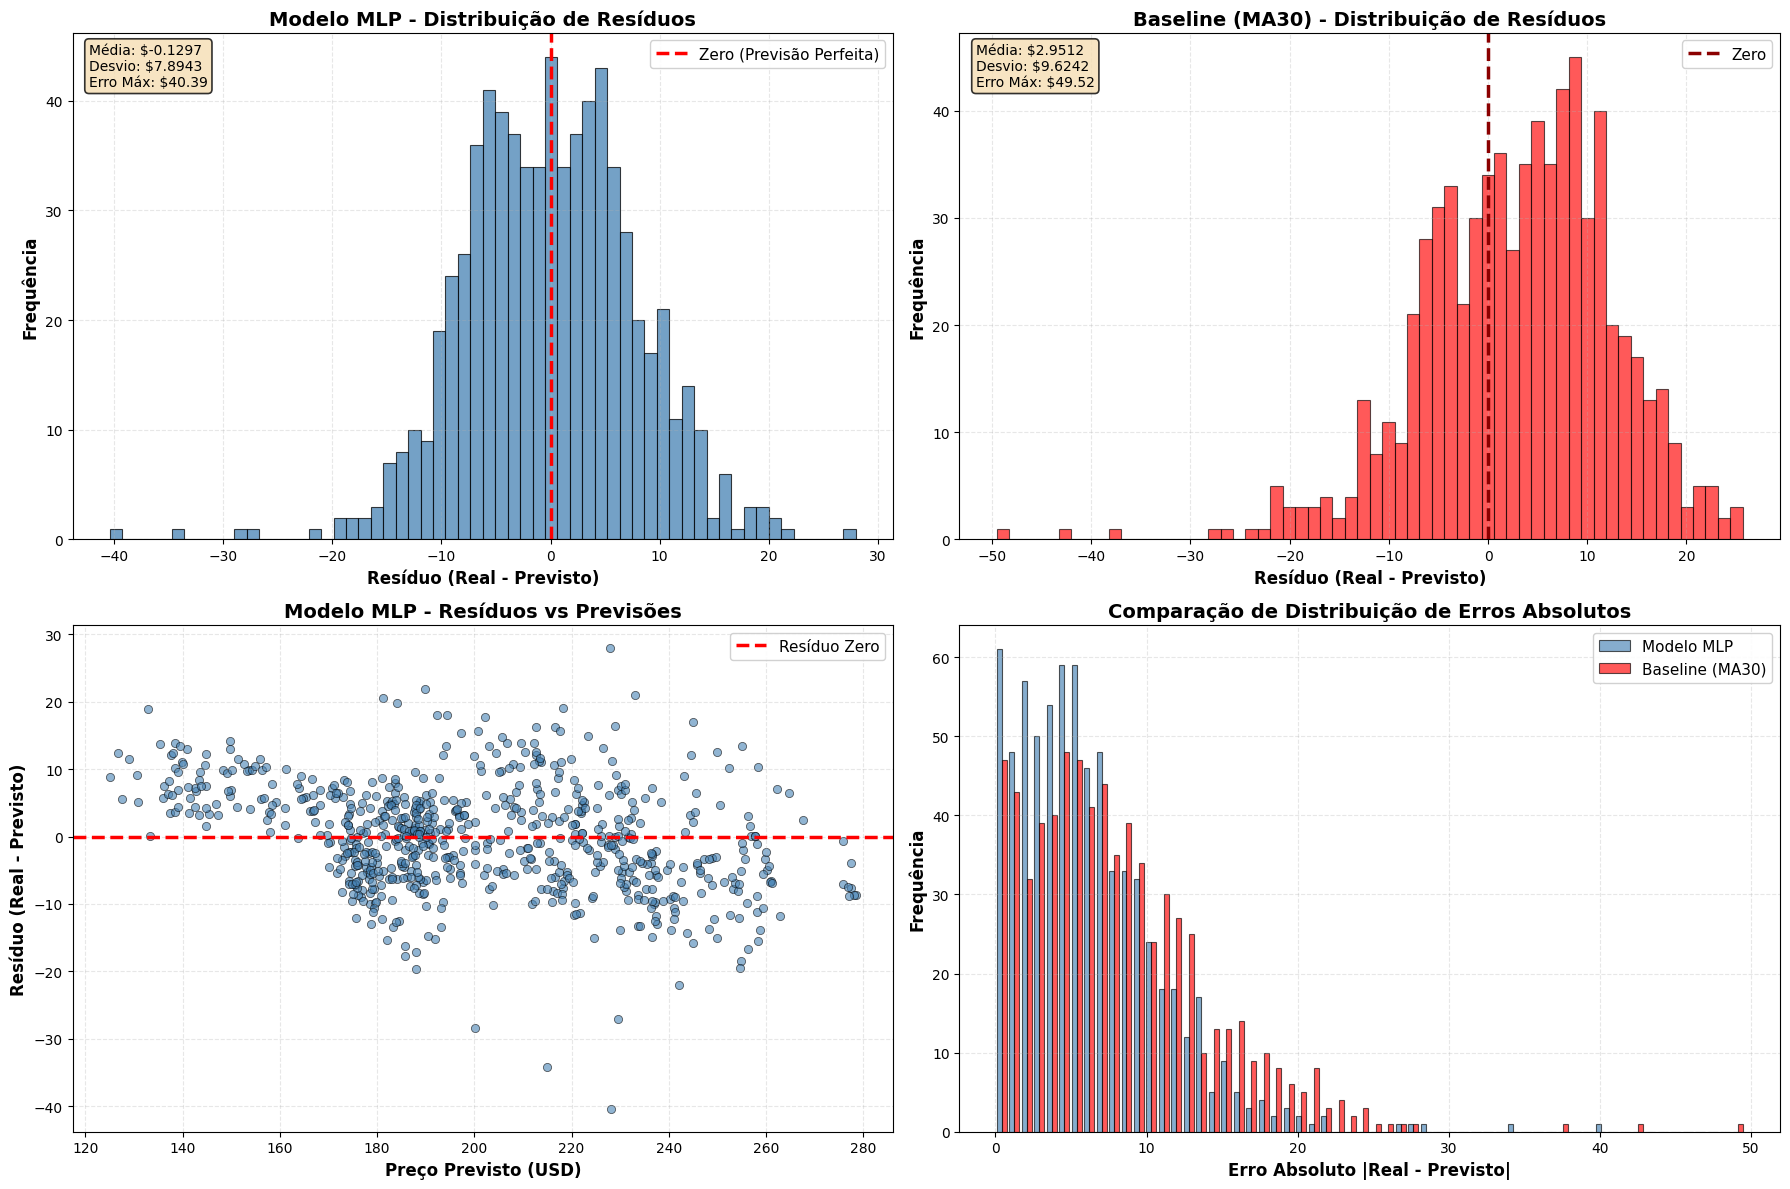

In [ ]:
# ============================================================================
# ANÁLISE DE RESÍDUOS
# ============================================================================
print("\n" + "="*70)
print("8. MÉTRICAS DE AVALIAÇÃO - ANÁLISE DE RESÍDUOS")
print("="*70)

residuos_mlp = y_teste - preds_mlp_keras
residuos_baseline = y_teste - baseline_janelado

# ============================================================================
# VISUALIZAÇÃO 7: GRÁFICOS DE RESÍDUOS
# ============================================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# -------------------------
# 1. Distribuição de Resíduos MLP
# -------------------------
axes[0, 0].hist(residuos_mlp, bins=60, color='steelblue', alpha=0.75, edgecolor='black', linewidth=0.8)
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2.5, label='Zero (Previsão Perfeita)')
axes[0, 0].set_xlabel('Resíduo (Real - Previsto)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Frequência', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Modelo MLP - Distribuição de Resíduos', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11, framealpha=0.9)
axes[0, 0].grid(True, alpha=0.3, linestyle='--')

stats_mlp = f'Média: ${residuos_mlp.mean():.4f}\nDesvio: ${residuos_mlp.std():.4f}\nErro Máx: ${np.abs(residuos_mlp).max():.2f}'
axes[0, 0].text(0.02, 0.98, stats_mlp, transform=axes[0, 0].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1.2), 
                fontsize=10)

# -------------------------
# 2. Distribuição de Resíduos Baseline
# -------------------------
axes[0, 1].hist(residuos_baseline, bins=60, color='red', alpha=0.65, edgecolor='black', linewidth=0.8)
axes[0, 1].axvline(x=0, color='darkred', linestyle='--', linewidth=2.5, label='Zero')
axes[0, 1].set_xlabel('Resíduo (Real - Previsto)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequência', fontsize=12, fontweight='bold')
axes[0, 1].set_title(f'Baseline (MA{INPUT_WIDTH}) - Distribuição de Resíduos', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11, framealpha=0.9)
axes[0, 1].grid(True, alpha=0.3, linestyle='--')

stats_base = f'Média: ${residuos_baseline.mean():.4f}\nDesvio: ${residuos_baseline.std():.4f}\nErro Máx: ${np.abs(residuos_baseline).max():.2f}'
axes[0, 1].text(0.02, 0.98, stats_base, transform=axes[0, 1].transAxes, va='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1.2), 
                fontsize=10)

# -------------------------
# 3. Resíduos vs Previsões (MLP)
# -------------------------
axes[1, 0].scatter(preds_mlp_keras, residuos_mlp, alpha=0.6, s=35, color='steelblue', 
                   edgecolors='black', linewidth=0.6)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2.5, label='Resíduo Zero')
axes[1, 0].set_xlabel('Preço Previsto (USD)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Resíduo (Real - Previsto)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Modelo MLP - Resíduos vs Previsões', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11, framealpha=0.9)
axes[1, 0].grid(True, alpha=0.3, linestyle='--')

# -------------------------
# 4. Comparação de Erros Absolutos
# -------------------------
erros_mlp = np.abs(residuos_mlp)
erros_baseline = np.abs(residuos_baseline)

axes[1, 1].hist([erros_mlp, erros_baseline], bins=60, 
                label=['Modelo MLP', f'Baseline (MA{INPUT_WIDTH})'], 
                color=['steelblue', 'red'], alpha=0.65, edgecolor='black', linewidth=0.8)
axes[1, 1].set_xlabel('Erro Absoluto |Real - Previsto|', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Frequência', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Comparação de Distribuição de Erros Absolutos', fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11, framealpha=0.9)
axes[1, 1].grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
